# U.S. Geological Survey Class GW3099

Advanced Modeling of Groundwater Flow (GW3099) <br>
Boise, Idaho <br>
September 16 - 20, 2024 <br>

# ![title](../../images/ClassLocation.jpg)

# Particle tracking example 1: backwards tracking in a steady flow field

![title](../../images/ex-prt-mp7-p01-config.png)

This notebook demonstrates particle tracking with MODFLOW programs.

We will solve a backwards tracking scenario in a steady-state flow field, building on [Example 1](https://modflow6-examples.readthedocs.io/en/develop/_notebooks/ex-prt-mp7-p01.html) from the MODPATH 7 user guide. This involves determining a capture area for the central well (see figure above).

First a MODFLOW 6 GWF model is run to produce a flow solution. Then a MODPATH 7 model and an equivalent MODFLOW 6 PRT model are run side-by-side, and their results compared. This is an opportunity to compare the features of MODPATH 7 and MODFLOW 6 PRT, and demonstrate how to migrate an existing MODPATH 7 simulation to PRT.

Import dependencies.

In [56]:
import pathlib as pl
import warnings

import flopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Enable inline plotting.

In [57]:
%matplotlib inline

Ignore some warnings.

In [58]:
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", DeprecationWarning)

Install the nightly build of MODFLOW 6.

In [59]:
flopy.utils.get_modflow(":python", subset="mf6", repo="modflow6-nightly-build")

auto-selecting option ':python' for 'bindir'
fetched release '20240913' info from MODFLOW-USGS/modflow6-nightly-build
using previous download '/Users/wbonelli/Downloads/modflow6_nightly-20240913-macarm.zip' (use 'force=True' to re-download)
extracting 1 file to '/Users/wbonelli/micromamba/envs/gw3099/bin'
mf6
updated flopy metadata file: '/Users/wbonelli/.local/share/flopy/get_modflow.json'


Make sure MODPATH 7 is installed.

In [60]:
flopy.utils.get_modflow(":python", subset="mp7")

auto-selecting option ':python' for 'bindir'
fetched release '19.0' info from MODFLOW-USGS/executables
using previous download '/Users/wbonelli/Downloads/modflow_executables-19.0-macarm.zip' (use 'force=True' to re-download)
extracting 1 file to '/Users/wbonelli/micromamba/envs/gw3099/bin'
mp7 (7.2.001)
updated flopy metadata file: '/Users/wbonelli/.local/share/flopy/get_modflow.json'


Create a base workspace.

In [61]:
example_name = "ex1"
base_ws = pl.Path("temp") / example_name
base_ws.mkdir(exist_ok=True, parents=True)

## Flow model

First we define a flow model which will be used by PRT and MP7.

Define the flow model name and workspace.

In [62]:
gwf_name = f"{example_name}-gwf"
gwf_ws = base_ws / "gwf"
gwf_ws.mkdir(exist_ok=True, parents=True)

Define flow model units.

In [63]:
length_units = "feet"
time_units = "days"

Define flow model parameters.

In [64]:
nper = 1  # Number of periods
nlay = 3  # Number of layers (base grid)
nrow = 21  # Number of rows (base grid)
ncol = 20  # Number of columns (base grid)
delr = 500.0  # Column width ($ft$)
delc = 500.0  # Row width ($ft$)
top = 400.0  # Top of the model ($ft$)
botm = [220.0, 200.0, 0.0]  # Layer bottom elevations ($ft$)
porosity = 0.1  # Soil porosity (unitless)
rch = 0.005  # Recharge rate ($ft/d$)
kh = [50.0, 0.01, 200.0]  # Horizontal hydraulic conductivity ($ft/d$)
kv = [10.0, 0.01, 20.0]  # Vertical hydraulic conductivity ($ft/d$)
wel_q = -150000.0  # Well pumping rate ($ft^3/d$)
riv_h = 320.0  # River stage ($ft$)
riv_z = 317.0  # River bottom ($ft$)
riv_c = 1.0e5  # River conductance ($ft^2/d$)

Define the initial structured grid. Later we will refine the grid, but for the first run we use a coarse discretization.

In [65]:
Lx = 10000.0
Ly = 10500.0
nlay = 3
nrow = 21
ncol = 20
delr = Lx / ncol
delc = Ly / nrow
top = 400
botm = [220, 200, 0]

Define the time discretization.

In [66]:
nstp = 1
perlen = 1000.0
tsmult = 1.0
tdis_rc = [(perlen, nstp, tsmult)]

Construct a simulation for the flow model.

In [67]:
gwf_sim = flopy.mf6.MFSimulation(
    sim_name=gwf_name, exe_name="mf6", version="mf6", sim_ws=gwf_ws
)

Create the time discretization.

In [68]:
tdis = flopy.mf6.ModflowTdis(
    gwf_sim,
    pname="tdis",
    time_units="DAYS",
    perioddata=tdis_rc,
    nper=len(tdis_rc),
)

Create the flow model.

In [69]:
gwf = flopy.mf6.ModflowGwf(
    gwf_sim, modelname=gwf_name, model_nam_file=f"{gwf_name}.nam"
)
gwf.name_file.save_flows = True

Create the discretization package.

In [70]:
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

Create the initial conditions package.

In [71]:
ic = flopy.mf6.ModflowGwfic(
    gwf, pname="ic", strt=top
)  # initial heads at river stage

Create the node property flow package.

In [72]:
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    icelltype=[1, 0, 0],
    k=kh,
    k33=kv,
    save_saturation=True,
    save_specific_discharge=True,
)

Define the model's boundary conditions. These include a well, a river, and recharge.

In [73]:
# Well package
wel_loc = (2, 10, 9)
wd = [(wel_loc, wel_q)]

# River package
riv_iface = 6
riv_iflowface = -1
rd = []
for i in range(nrow):
    rd.append(
        [(0, i, ncol - 1), riv_h, riv_c, riv_z, riv_iface, riv_iflowface]
    )

# Recharge package
rch_iface = 6
rch_iflowface = -1

Define well and river cell numbers, used to extract and plot model results later.

In [74]:
nodes = {}
k, i, j = wel_loc
nodes["well"] = [ncol * (nrow * k + i) + j]
nodes["river"] = []
for rivspec in rd:
    k, i, j = rivspec[0]
    node = ncol * (nrow * k + i) + j
    nodes["river"].append(node)

Create the recharge, well, and river packages.

In [75]:
# Instantiate the MODFLOW 6 gwf recharge package
rcha = flopy.mf6.modflow.mfgwfrcha.ModflowGwfrcha(
    gwf,
    recharge=rch,
    auxiliary=["iface", "iflowface"],
    aux=[rch_iface, rch_iflowface],
)

# Instantiate the MODFLOW 6 gwf well package
wel = flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(
    gwf, maxbound=1, stress_period_data={0: wd}
)

# Instantiate the MODFLOW 6 gwf river package
riv = flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(
    gwf, auxiliary=["iface", "iflowface"], stress_period_data={0: rd}
)

Create the output control package.

In [76]:
# Define output file names
headfile_name = f"{gwf_name}.hds"
budgetfile_name = f"{gwf_name}.cbb"

# Create package
head_record = [headfile_name]
budget_record = [budgetfile_name]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
    gwf,
    pname="oc",
    saverecord=saverecord,
    head_filerecord=head_record,
    budget_filerecord=budget_record,
)

Create the solver package.

In [77]:
ims = flopy.mf6.ModflowIms(
    gwf_sim,
    pname="ims",
    complexity="SIMPLE",
    outer_dvclose=1e-6,
    inner_dvclose=1e-6,
    rcloserecord=1e-6,
)

Write and run the flow model.

In [78]:
gwf_sim.write_simulation(silent=False)
gwf_sim.run_simulation(silent=False)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model ex1-gwf...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package wel_0...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../../micromamba/envs/gw3099/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.6.0.dev0 (preliminary) 09/13/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Sep 13 2024 02:50:39 with GCC version 13.3.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need 

(True, [])

Load heads.

In [79]:
hds = gwf.output.head().get_data()

Plot heads. Define a function for it which we will reuse later.

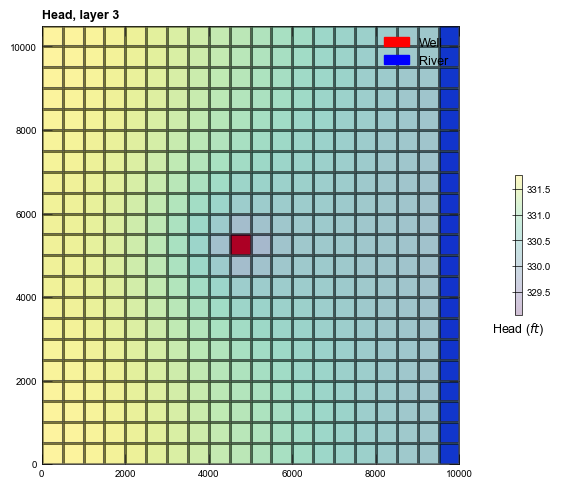

In [80]:
from matplotlib.patches import Patch


def plot_heads(ax, gwf, heads):
    mm = flopy.plot.PlotMapView(gwf, ax=ax, layer=2)
    mm.plot_grid(alpha=0.25)
    mm.plot_bc("WEL", plotAll=True, color="red")
    mm.plot_bc("RIV", plotAll=True, color="blue")
    pc = mm.plot_array(heads, edgecolor="black", alpha=0.25)
    cb = plt.colorbar(pc, shrink=0.25, pad=0.1)
    cb.ax.set_xlabel(r"Head ($ft$)")
    return mm


with flopy.plot.styles.USGSPlot():
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.set_aspect("equal")
    ax.legend(
        handles=[
            Patch(color="red", label="Well"),
            Patch(color="blue", label="River"),
        ],
    )
    fig.tight_layout()
    flopy.plot.styles.heading(ax, heading="Head, layer 3")
    plot_heads(ax, gwf, hds[2, :, :])
    plt.show()

## Tracking models

We now define a MODPATH 7 particle tracking simulation, then an equivalent PRT simulation.

### MP7 model

Define the MP7 model name and workspace.

In [81]:
mp7_name = f"{example_name}-mp7"
mp7_ws = base_ws / "mp7"
mp7_ws.mkdir(exist_ok=True, parents=True)

Now we can create the MP7 model. First define the expected pathline output file.

In [82]:
mp7_pathline_file_path = mp7_ws / f"{mp7_name}.mppth"

Create the model object.

In [83]:
mp7 = flopy.modpath.Modpath7(
    modelname=mp7_name,
    flowmodel=gwf,
    exe_name="mp7",
    model_ws=mp7_ws,
    budgetfilename=budgetfile_name,
    headfilename=headfile_name,
)

Create the MP7 basic input data package.

In [84]:
mp7_bas = flopy.modpath.Modpath7Bas(
    mp7, porosity=porosity, defaultiface={"RCH": 6, "EVT": 6}
)

The next step is to define a particle release configuration. We will release particles from the lateral faces of the cell containing the well. To do this we use MODPATH 7 particle input style 2, subdivision style 1.

In [85]:
mp7_face_data = flopy.modpath.FaceDataType(
    verticaldivisions1=5,
    verticaldivisions2=5,
    verticaldivisions3=5,
    verticaldivisions4=5,
    horizontaldivisions1=5,
    horizontaldivisions2=5,
    horizontaldivisions3=5,
    horizontaldivisions4=5,
    rowdivisions5=0,
    rowdivisions6=0,
    columndivisions5=0,
    columndivisions6=0,
)
mp7_particle_data = flopy.modpath.LRCParticleData(
    subdivisiondata=[mp7_face_data], lrcregions=[[[*wel_loc, *wel_loc]]]
)
mp7_pg1 = flopy.modpath.ParticleGroupLRCTemplate(
    particlegroupname="PG1",
    particledata=mp7_particle_data,
    filename=mp7_name + "pg1.sloc",
)

Define a zone map. The active region is zone 0, and the two boundaries are 1 and 2, respectively. MP7 and PRT will assign each particle path record to a zone. This will make it easier to identify the boundary condition where a given particle terminates.

In [86]:
izone = np.zeros((nlay, nrow, ncol), dtype=int)
for l, r, c in gwf.modelgrid.get_lrc(nodes["well"]):
    izone[l, r, c] = 1
for l, r, c in gwf.modelgrid.get_lrc(nodes["river"]):
    izone[l, r, c] = 2

Create the MP7 simulation.

In [87]:
mp7_sim = flopy.modpath.Modpath7Sim(
    mp7,
    simulationtype="combined",
    trackingdirection="backward",
    weaksinkoption="pass_through",
    weaksourceoption="pass_through",
    budgetoutputoption="summary",
    referencetime=[0, 0, 0.0],
    stoptimeoption="extend",
    timepointdata=[500, 1000.0],
    zonedataoption="on",
    zones=izone,
    particlegroups=[mp7_pg1],
)

Run the MP7 simulation.

In [88]:
mp7.write_input()
mp7.run_model(silent=False)

FloPy is using the following executable to run the model: ../../../../../../../micromamba/envs/gw3099/bin/mp7

MODPATH Version 7.2.001   
Program compiled Jun 21 2024 02:56:57 with GFORTRAN compiler (ver. 12.3.0)      


Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+03  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
       100 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         0 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

Load MP7 pathline results. FloPy returns a list of `np.recarray`, one for each pathline; we merge the pathlines into a single dataframe.

In [89]:
mp7_pathline_file = flopy.utils.PathlineFile(mp7_pathline_file_path)
mp7_pathlines = pd.concat(
    [pd.DataFrame(pl) for pl in mp7_pathline_file.get_alldata()]
)
mp7_pathlines

,particleid,particlegroup,sequencenumber,particleidloc,time,x,y,z,k,node,xloc,yloc,zloc,stressperiod,timestep
0,0,0,0,0,0.000000,4500.000000,5050.000000,20.000000,2,1049,0.000000,0.100000,0.100000,1,1
1,0,0,0,0,0.000000,4500.000000,5050.000000,20.000000,2,1049,0.000000,0.100000,0.100000,1,1
2,0,0,0,0,55.099941,4295.363770,5000.000000,20.184050,2,1048,0.590727,0.000000,0.100920,1,1
3,0,0,0,0,266.553864,4000.000000,4786.857910,20.879211,2,1068,0.000000,0.573716,0.104396,1,1
4,0,0,0,0,671.823547,3500.000000,4601.118164,22.321342,2,1067,0.000000,0.202236,0.111607,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,99,0,99,99,3271.038086,4000.000000,6487.940918,277.793488,0,168,0.000000,0.975881,0.494794,1,1
12,99,0,99,99,4000.000000,3635.930908,6498.729980,309.707642,0,167,0.271862,0.997460,0.764556,1,1
13,99,0,99,99,4085.572021,3595.872803,6500.000000,313.656006,0,167,0.191745,1.000000,0.798207,1,1
14,99,0,99,99,4296.375488,3500.000000,6503.130371,323.594635,0,147,0.000000,0.006261,0.882800,1,1


Plot MP7 results.

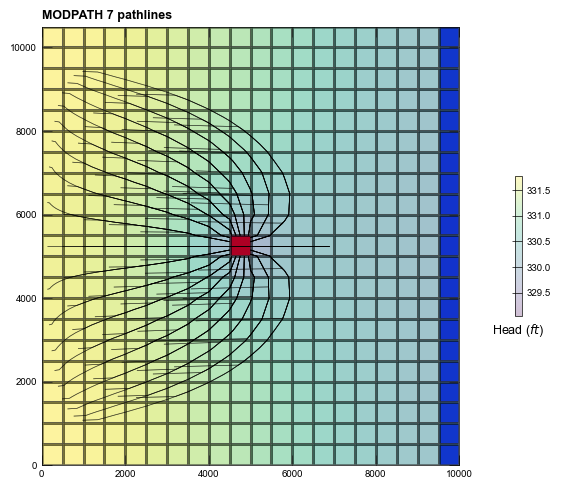

In [90]:
with flopy.plot.styles.USGSPlot():
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.set_aspect("equal")
    fig.tight_layout()
    flopy.plot.styles.heading(ax, heading="MODPATH 7 pathlines")
    mm = plot_heads(ax, gwf, hds[2, :, :])
    mm.plot_pathline(
        mp7_pathlines, layer="all", colors="black", alpha=0.5, linewidth=0.5
    )
    plt.show()



### PRT model

Define the PRT model name and workspace.

In [91]:
prt_name = f"{example_name}-prt"
prt_ws = base_ws / "prt"
prt_ws.mkdir(exist_ok=True, parents=True)

Create a PRT simulation.

In [92]:
prt_sim = flopy.mf6.MFSimulation(
    sim_name=prt_name, exe_name="mf6", version="mf6", sim_ws=prt_ws
)

Create the temporal discretization.

In [93]:
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    prt_sim,
    pname="tdis",
    time_units="DAYS",
    nper=nper,
    perioddata=[(perlen, nstp, tsmult)],
)

Create the PRT model.

In [94]:
prt = flopy.mf6.ModflowPrt(
    prt_sim, modelname=prt_name, model_nam_file=f"{prt_name}.nam"
)

Create the discretization package.

In [95]:
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
    prt,
    pname="dis",
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    length_units="FEET",
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

Create the PRT model input package.

In [96]:
mip = flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=porosity, izone=izone)

Create the particle release package. We will use a conversion utility which makes it straightforward to convert a MODPATH 7 particle release configuration to the format expected by PRT's particle release point (PRP) package.

In [97]:
release_pts = list(mp7_particle_data.to_prp(gwf.modelgrid))
prp = flopy.mf6.ModflowPrtprp(
    prt,
    # filename=f"{prt_name}1.prp",
    nreleasepts=len(release_pts),
    packagedata=release_pts,
    perioddata={
        0: ["FIRST"],
    },
    exit_solve_tolerance=1e-5,
    extend_tracking=True,
)

Create the output control package.

PRT can write pathline output to binary or CSV files. Below we will enable both, but will only read the CSV output file.

The output control package is also used to configure tracking events. This is another point of departure between PRT and MODPATH. MP7 supports four distinct simulation modes:

- endpoint
- pathline
- timeseries
- combined pathline/timeseries

The tracking algorithm used by MP7 is functionally identical in all four modes; the mode controls only how output is reported.

PRT has a single mode. Output is configured by selecting tracking events:

- release
- (sub)cell exit
- timestep end
- termination
- weak sink cell exit
- user-specified time

Some exercises:

<details>
  <summary>Q: How to configure a PRT model like an MP7 endpoint simulation?</summary>
  A: Select release and termination events only.
</details>

<details>
  <summary>Q: How to configure a model like an MP7 timeseries simulation?</summary>
  A: Select time reporting and provide tracking times.
</details>

By default, PRT enables all tracking events.

In [98]:
# Define output files.
budgetfile_prt = f"{prt_name}.cbb"
trackfile_prt = f"{prt_name}.trk"
trackhdrfile_prt = f"{prt_name}.trk.hdr"
trackcsvfile_prt = f"{prt_name}.trk.csv"

# Define the output control package.
budget_record = [budgetfile_prt]
track_record = [trackfile_prt]
trackcsv_record = [trackcsvfile_prt]
tracktimes = list(range(0, 72000, 1000))
oc = flopy.mf6.ModflowPrtoc(
    prt,
    pname="oc",
    budget_filerecord=budget_record,
    track_filerecord=track_record,
    trackcsv_filerecord=trackcsv_record,
    ntracktimes=len(tracktimes),
    tracktimes=[(t,) for t in tracktimes],
    saverecord=[("BUDGET", "ALL")],
)

Create the flow model interface. Since PRT does not yet support backwards tracking natively, we'll reverse the flow model's head and budget output files with FloPy first.

In [99]:
head_file = flopy.utils.HeadFile(gwf_ws / headfile_name, tdis=gwf_sim.tdis)
budget_file = flopy.utils.CellBudgetFile(
    gwf_ws / budgetfile_name, precision="double", tdis=gwf_sim.tdis
)

headfile_bkwd_name = f"{headfile_name}_bkwd"
budgetfile_bkwd_name = f"{budgetfile_name}_bkwd"

head_file.reverse(prt_ws / headfile_bkwd_name)
budget_file.reverse(prt_ws / budgetfile_bkwd_name)

fmi = flopy.mf6.ModflowPrtfmi(
    prt,
    packagedata=[
        ("GWFHEAD", pl.Path(f"../{prt_ws.name}/{headfile_bkwd_name}")),
        ("GWFBUDGET", pl.Path(f"../{prt_ws.name}/{budgetfile_bkwd_name}")),
    ],
)

Create an explicit model solution for the PRT model. PRT is unlike other MODFLOW 6 model types in that it includes its own solution procedures for particle tracking. PRT does not use the iterative matrix solvers used by other model types, instead it uses an "explicit" solution.

In [100]:
ems = flopy.mf6.ModflowEms(
    prt_sim,
    pname="ems",
    filename=f"{prt_name}.ems",
)
prt_sim.register_solution_package(ems, [prt.name])

Write and run the PRT model.

In [101]:
prt_sim.write_simulation()
prt_sim.run_simulation(silent=False)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ems...
  writing model ex1-prt...
    writing model name file...
    writing package dis...
    writing package mip...
    writing package prp_0...
    writing package oc...
    writing package fmi...
FloPy is using the following executable to run the model: ../../../../../../../micromamba/envs/gw3099/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.6.0.dev0 (preliminary) 09/13/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Sep 13 2024 02:50:39 with GCC version 13.3.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the US

(True, [])

Load the PRT pathlines.

In [102]:
prt_pathlines = pd.read_csv(prt_ws / trackcsvfile_prt)
prt_pathlines

,kper,kstp,imdl,iprp,irpt,ilay,icell,izone,istatus,ireason,trelease,t,x,y,z,name
0,1,1,1,1,1,3,1050,1,1,0,0.0,0.000000,4500.000000,5050.000000,20.000000,NaN
1,1,1,1,1,1,3,1050,1,1,1,0.0,0.000000,4500.000000,5050.000000,20.000000,NaN
2,1,1,1,1,1,3,1049,0,1,5,0.0,0.000000,4500.000000,5050.000000,20.000000,NaN
3,1,1,1,1,1,3,1049,0,1,1,0.0,55.099943,4295.363629,5000.000000,20.184050,NaN
4,1,1,1,1,1,3,1069,0,1,1,0.0,266.553875,4000.000000,4786.858002,20.879212,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2600,1,1,1,1,100,1,168,0,1,5,0.0,4000.000000,3635.931020,6498.729757,309.707639,NaN
2601,1,1,1,1,100,1,168,0,1,1,0.0,4085.572033,3595.872656,6500.000000,313.656014,NaN
2602,1,1,1,1,100,1,148,0,1,1,0.0,4296.375355,3500.000000,6503.130627,323.594619,NaN
2603,1,1,1,1,100,1,147,0,1,1,0.0,4578.087022,3377.028290,6506.590878,337.794214,NaN


Plot the PRT pathlines superimposed over the MP7 pathlines, this time in 3D with PyVista.

The first step is to export the models to VTK. Then we create meshes to show the confining bed and boundary conditions.

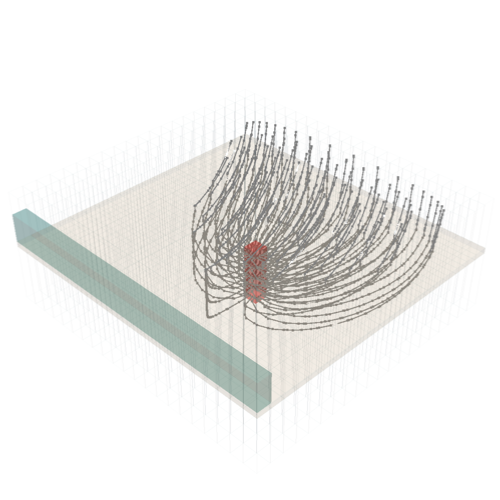

In [103]:
try:
    import pyvista as pv
    from flopy.export.vtk import Vtk

    vert_exag = 10

    vtk = Vtk(
        model=gwf, binary=False, vertical_exageration=vert_exag, smooth=False
    )
    vtk.add_model(gwf)
    vtk.add_pathline_points(mp7_pathlines.to_records(index=False))
    gwf_mesh, mp7_mesh = vtk.to_pyvista()

    # this is a little awkward due to the design of `Vtk`, which can only
    # have one set of pathlines at a time.
    vtk = Vtk(
        model=gwf, binary=False, vertical_exageration=vert_exag, smooth=False
    )
    vtk.add_model(gwf)
    vtk.add_pathline_points(prt_pathlines.to_records(index=False))
    _, prt_mesh = vtk.to_pyvista()

    def get_nn(k, i, j):
        """Convert a structured grid cell index to a node number."""
        return k * nrow * ncol + i * ncol + j

    # add meshes
    riv_mesh = pv.Box(
        bounds=[
            gwf.modelgrid.extent[1] - delc,
            gwf.modelgrid.extent[1],
            gwf.modelgrid.extent[2],
            gwf.modelgrid.extent[3],
            botm[0] * vert_exag,
            hds[(0, 0, ncol - 1)] * vert_exag,
        ]
    )
    well_cellid = get_nn(0, *wel_loc[1:])
    well_points = gwf.modelgrid.verts[gwf.modelgrid.iverts[well_cellid]]
    well_xs, well_ys = list(zip(*well_points))
    wel_mesh = pv.Box(
        bounds=[
            min(well_xs),
            max(well_xs),
            min(well_ys),
            max(well_ys),
            botm[-1] * vert_exag,
            botm[-2] * vert_exag,
        ]
    )
    bed_mesh = pv.Box(
        bounds=[
            gwf.modelgrid.extent[0],
            gwf.modelgrid.extent[1],
            gwf.modelgrid.extent[2],
            gwf.modelgrid.extent[3],
            botm[1] * vert_exag,
            botm[0] * vert_exag,
        ]
    )

    # create the plot
    axes = pv.Axes(show_actor=False, actor_scale=2.0, line_width=5)
    pv.set_jupyter_backend("static")
    # pv.set_jupyter_backend("trame")
    p = pv.Plotter(
        window_size=[500, 500],
        notebook=True,
    )
    p.enable_anti_aliasing()
    p.add_mesh(gwf_mesh, opacity=0.025, style="wireframe")
    p.add_mesh(
        mp7_mesh,
        point_size=5,
        line_width=2.5,
        smooth_shading=True,
        color="white",
    )
    p.add_mesh(
        prt_mesh,
        point_size=5,
        line_width=2.5,
        smooth_shading=True,
        color="gray",
    )
    p.add_mesh(riv_mesh, color="teal", opacity=0.2)
    p.add_mesh(wel_mesh, color="red", opacity=0.3)
    p.add_mesh(bed_mesh, color="tan", opacity=0.1)
    p.show()
except:
    print("PyVista not found.")

<details>
  <summary>Q: How can we determine the capture area?</summary>
  A: First, filter the pathlines and find terminating points where the particles reach the water table. Then compute the convex hull of the point set and calculate its area.
</details>

In [104]:
termination_pts = prt_pathlines[prt_pathlines.ireason == 3].set_index("irpt")[
    ["x", "y", "z"]
]
termination_pts

,x,y,z
irpt,,,
1,177.528580,3358.176413,339.059486
2,134.866700,4210.515575,339.048235
3,117.533401,5250.000000,339.043887
4,134.866700,6289.484426,339.048235
5,177.528580,7141.823587,339.059486
...,...,...,...
96,2610.748895,6152.215682,338.156004
97,2747.147933,6405.550493,338.156004
98,2914.404820,6561.210471,338.166033


Create a multi-point geometry.

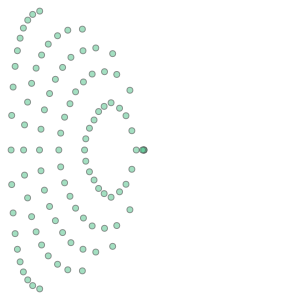

In [105]:
from shapely import MultiPoint

term_pts = MultiPoint(termination_pts.to_numpy())
term_pts

Compute the area of the convex hull.

Capture area:  2.51e+07 sq feet,     0.899 sq mi


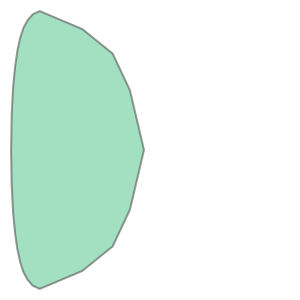

In [106]:
from shapely import convex_hull

chull = convex_hull(term_pts)
chull_area_ft = chull.area
chull_area_mi = chull.area / (5280 * 5280)
print(
    f"Capture area: {chull.area:9.3} sq {length_units}, {chull_area_mi:9.3} sq mi"
)
chull

Plot the capture area in map view.

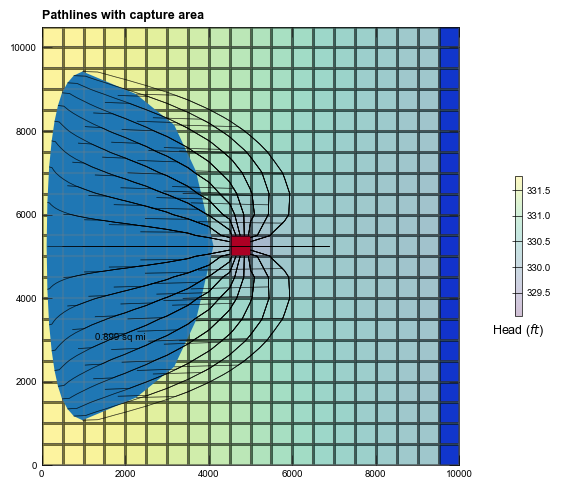

In [111]:
with flopy.plot.styles.USGSPlot():
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.set_aspect("equal")
    fig.tight_layout()
    flopy.plot.styles.heading(ax, heading="Pathlines with capture area")
    mm = plot_heads(ax, gwf, hds[2, :, :])
    mm.plot_pathline(
        mp7_pathlines, layer="all", colors="black", alpha=0.5, linewidth=0.5
    )
    chull_xs, chull_ys, _ = map(list, zip(*list(chull.exterior.coords)))
    ax.fill(chull_xs, chull_ys)
    ax.annotate(f"{chull_area_mi:9.3f} sq mi", (1000, 3000), color="white")
    plt.show()

## Exercises

1. Determine a travel time distribution and plot endpoints colored by travel time.
2. Vary the particle configuration and determine the effect on the capture area.
3. Refine the grid around the well and determine the effect on the capture area.

To solve part 1 we can select endpoints from the set of pathlines, extract travel times, and compute some statistics, then map the travel times to a color gradient in an endpoint plot.

In [108]:
# TODO

To solve part 2 we can change the particle release configuration above and rerun the notebook.

In [109]:
# TODO

To solve part 3 we can use GRIDGEN to refine the grid around the well, then rerun the notebook to see the effect on pathlines and capture area.

In [110]:
# TODO